# Showing Backpropagation Correctness

First, we initialize the system we will use to test the correctness of our gradients.

$$\newcommand{\T}{^T}$$
$$\newcommand{\B}{\mathcal{B}}$$
$$\newcommand{\es}{\emptyset}$$
$$\newcommand{\RR}{\mathbb{R}}$$
$$\newcommand{\BP}{\begin{proof}}$$
$$\newcommand{\EP}{\end{proof}}$$
$$\newcommand{\ZZ}{\mathbb{Z}}$$
$$\newcommand{\eps}{\varepsilon}$$
$$\newcommand{\diag}{\text{ diag}}$$
$$\newcommand{\inv}{^{-1}}$$

In [4]:
import numpy as np
import matplotlib.pyplot as plt

dim = 5

def check(f, grad_f, positive_only):

    if positive_only:
        x = np.random.rand(dim)
        v = np.random.rand(dim)
    else:
        x = np.random.randn(dim)
        v = np.random.randn(dim)

    max_iters = 32
    h = np.zeros(max_iters)
    err0 = np.zeros(max_iters)
    err1 = np.zeros(max_iters)

    for i in range(max_iters):
        h[i] = 2**(-i) # halve our stepsize every time

        fv = f(x + h[i]*v)
        T0 = f(x)

        T1 = T0 + h[i]*np.matmul(grad_f(x).transpose(), v)

        err0[i] = np.linalg.norm(fv - T0) # this error should be linear
        err1[i] = np.linalg.norm(fv - T1) # this error should be quadratic

        # print('h = ', h, ', err0 = ', err0[i], ', err1 = ', err1[i])

        #print('h: %.3e, \t err0: %.3e, \t err1: %.3e' % (h[i], err0[i], err1[i]))

    plt.loglog(h, err0, linewidth=3)
    plt.loglog(h, err1, linewidth=3)
    plt.legend(['$\|f(x) - T_0(x)\|$', '$\|f(x)-T_1(x)\|$'], fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

### Simple test case: showing that $\nabla(Ax) = A\T$:

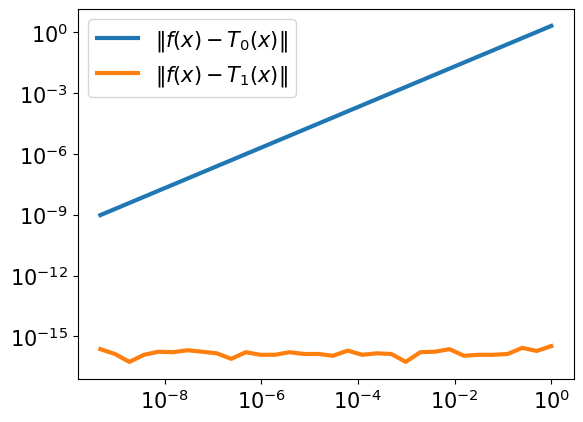

In [5]:
A = np.random.rand(dim, dim)

def f(x):
  return A.dot(x)

def grad_f(x):
  return np.transpose(A)

check(f, grad_f, False)

### Our graph proves that we have it right! We need the orange line to always start below and have a slope greater than our blue line (blue line shows linear error, orange line should show quadratic error)

### We're going to use tanh as our nonlinear activation function. First, we test the assumption that $\nabla(\tanh(x)) = \diag(1-\tanh^2(x))$:

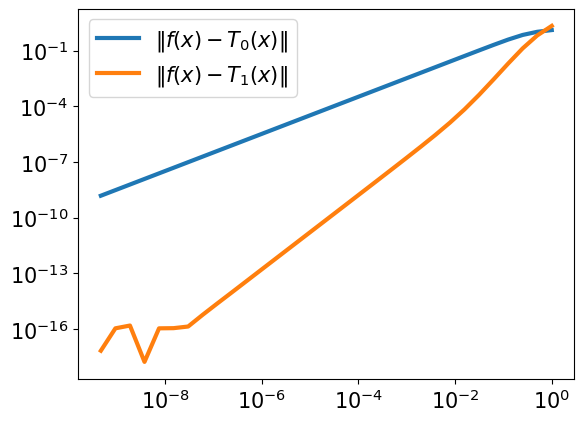

In [6]:
def f(x):
  return np.tanh(x)

def grad_f(x):
  return np.diag(1 - np.power(np.tanh(x), 2))

check(f, grad_f, False)

### Quick sanity check, showing that $\nabla((Ax)\T w) = A\T w$:

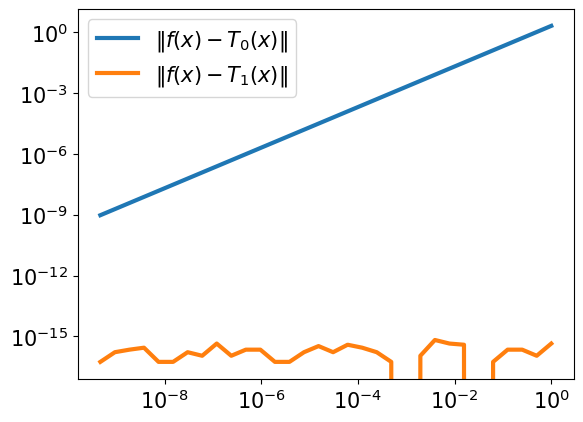

In [7]:
A = np.random.rand(dim, dim)
w = np.random.randn(dim)

def f(x):
  return (A @ x).transpose() @ w

def grad_f(x):
  return A.transpose() @ w

check(f, grad_f, False)

### Applying the chain rule, we first show that the bias gradient $\nabla_b(\tanh(Wz + b)\T v) = \diag(1-\tanh^2(z))v$

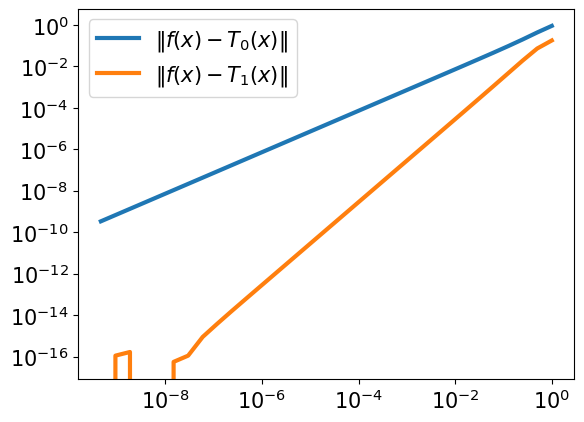

In [8]:
v = np.random.randn(dim)
z = np.random.randn(dim)
W = np.random.rand(dim, dim)

def f(b):
  return np.tanh((W @ z) + b).transpose() @ v

def grad_f(b):
  return np.diag(1 - np.power(np.tanh((W @ z) + b), 2)) @ v

check(f, grad_f, False)

### We can simplify this by writing $\sigma(x) = \tanh(x)$ and thus $\nabla \sigma(x) = \sigma'(x) = \diag(1-\tanh^2(x))$, we have $\nabla_b(\sigma(Wx + b)\T v) = \sigma'(Wx + b)v$:

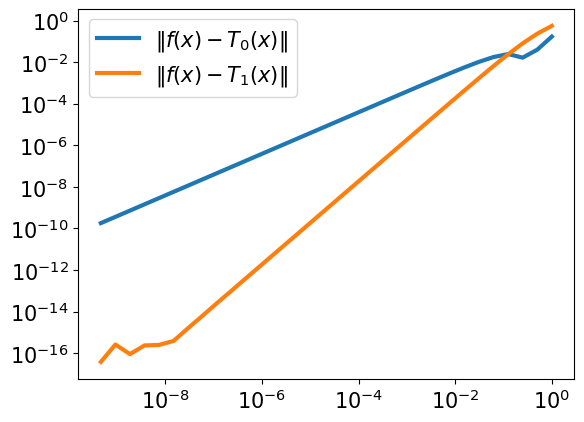

In [9]:
v = np.random.randn(dim)
z = np.random.randn(dim)
W = np.random.rand(dim, dim)

# helpers

def sigma(z):
  return np.tanh(z)

def sigma_prime(z):
  return np.diag(1 - np.power(np.tanh(z), 2))

# showing that this stays consistent

def f(b):
  return sigma((W @ z) + b).transpose() @ v

def grad_f(b):
  return sigma_prime((W @ z) + b) @ v

check(f, grad_f, False)

### Before we solve for the weights, we need to establish some tooling and facts. First, let's extend the check function to work with matricies:

In [10]:
def check_matrix(f, grad_f, positive_only):

    if positive_only:
        x = np.reshape(np.random.rand(dim*dim), (dim, dim))
        v = np.reshape(np.random.rand(dim*dim), (dim, dim))
    else:
        x = np.reshape(np.random.randn(dim*dim), (dim, dim))
        v = np.reshape(np.random.randn(dim*dim), (dim, dim))

    max_iters = 32
    h = np.zeros(max_iters)
    err0 = np.zeros(max_iters)
    err1 = np.zeros(max_iters)

    for i in range(max_iters):
        h[i] = 2**(-i) # halve our stepsize every time

        fv = f(x + h[i]*v)
        T0 = f(x)
        grad = grad_f(x)

        T1 = T0 + h[i]*np.matmul(grad.flatten(), v.flatten())

        err0[i] = np.linalg.norm(fv - T0) # this error should be linear
        err1[i] = np.linalg.norm(fv - T1) # this error should be quadratic

        # print('h = ', h, ', err0 = ', err0[i], ', err1 = ', err1[i])

        #print('h: %.3e, \t err0: %.3e, \t err1: %.3e' % (h[i], err0[i], err1[i]))

    plt.loglog(h, err0, linewidth=3)
    plt.loglog(h, err1, linewidth=3)
    plt.legend(['$\|f(x) - T_0(x)\|$', '$\|f(x)-T_1(x)\|$'], fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

### We test this on a simple case: $\nabla_W((Wa)\T b) = b a\T$:

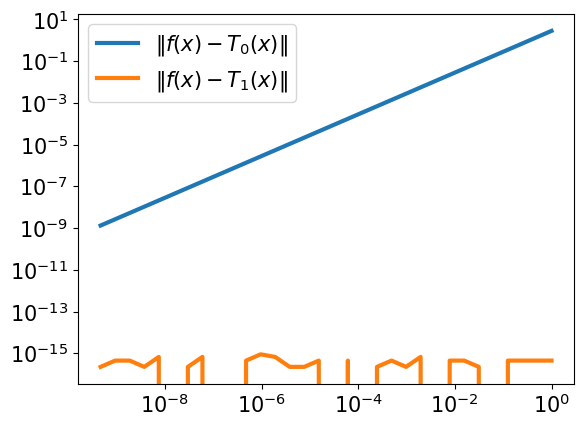

In [11]:
a = np.random.randn(dim)
b = np.random.randn(dim)

def f(W):
  return (W @ a).transpose() @ b

def grad_f(W):
  return np.outer(b, a)

check_matrix(f, grad_f, False)

### From there, we can guess that our weight gradient will be $\nabla_W(\sigma(Wx + b)\T ) = (\nabla_{Wx}(\sigma(Wx + b)\T v))x\T = (\sigma'(Wx + b)v)x\T$

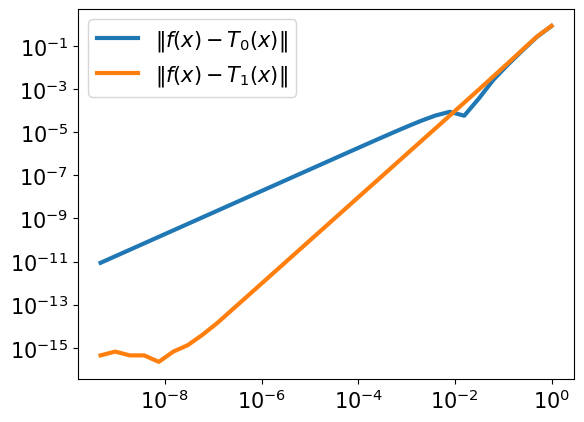

In [12]:
v = np.random.randn(dim)
x = np.random.randn(dim)
b = np.random.randn(dim)

# showing that this stays consistent

def f(W):
  return sigma((W @ x) + b).transpose() @ v

def grad_f(W):
  return np.outer(sigma_prime((W @ x) + b) @ v, x)

check_matrix(f, grad_f, False)

# Next, we extend to a two-layer nueral network case.

### Once again we'll start with the bias, by first showing that $\nabla_b(W_2\sigma(W_1z+b)+b_2) = \sigma'(W_1 z + b) W_2\T$

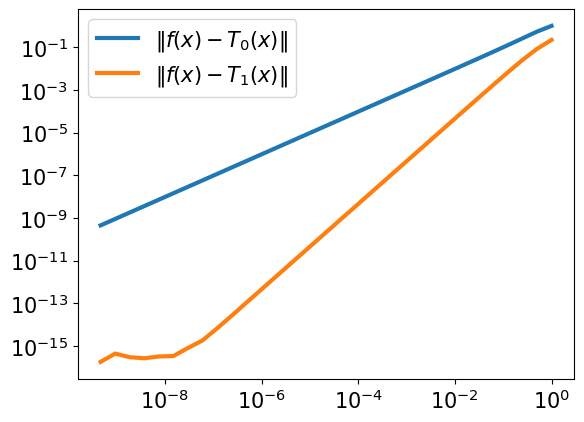

In [13]:
v = np.random.randn(dim)
z = np.random.randn(dim)
b2 = np.random.randn(dim)
W1 = np.random.rand(dim, dim)
W2 = np.random.rand(dim, dim)

# functions we care about

def f(b):
  return W2 @ sigma(W1 @ z + b) + b2

def grad_f(b):
  return sigma_prime(W1 @ z + b) @ W2.transpose()

check(f, grad_f, False)

### Then it follows that $\nabla_b(\sigma(W_2\sigma(W_1z+b)+b_2))\T v = \sigma'(W_1 z + b) W_2\T \sigma'(W_2\sigma(W_1z+b)+b_2) v$

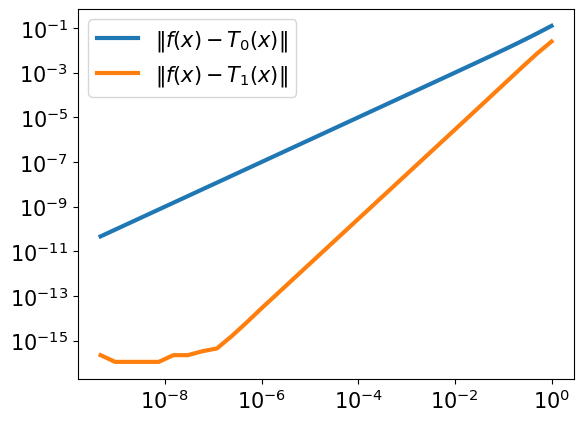

In [14]:
v = np.random.randn(dim)
z = np.random.randn(dim)
b2 = np.random.randn(dim)
W1 = np.random.rand(dim, dim)
W2 = np.random.rand(dim, dim)

# functions we care about

def f(b):
  return sigma(W2 @ sigma(W1 @ z + b) + b2).transpose() @ v

def grad_f(b):
  return (sigma_prime(W1 @ z + b) @ W2.transpose() @ sigma_prime(W2 @ sigma(W1 @ z + b) + b2)) @ v

check(f, grad_f, False)

### Next, we do the same for our weights, so we have $\nabla_W(\sigma(W_2\sigma(Wz+b)+b_2))\T v = (\nabla_{Wx}(\sigma(W_2\sigma(Wz+b)+b_2))\T v) x\T = (\sigma'(W_1 z + b) W_2\T \sigma'(W_2\sigma(W_1z+b)+b_2) v) x\T$

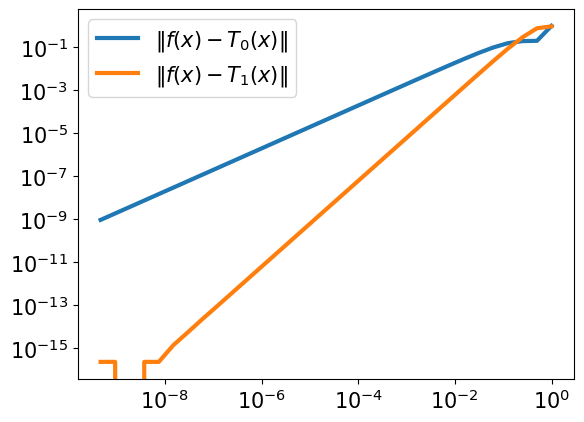

In [15]:
v = np.random.randn(dim)
x = np.random.randn(dim)
b = np.random.randn(dim)
W2 = np.random.rand(dim, dim)

# showing that this stays consistent

def f(W):
  return sigma(W2 @ sigma(W @ x + b) + b2).transpose() @ v

def grad_f(W):
  return np.outer((sigma_prime(W @ x + b) @ W2.transpose() @ sigma_prime(W2 @ sigma(W @ x + b) + b2)) @ v, x)

check_matrix(f, grad_f, False)

# Finally, we extend to the general case!

### We start again with the bias. First, we define our problem:

Let $L_n = \sigma(W_n L_{n-1} + b_n)$, with $L_{-1} = z$. We'd like to find $\nabla_b(L_n\T v)$.


The recursive formula $\nabla_b(L_n) = \nabla_b(L_{n-1}) W_n\T \sigma'(W_n L_{n-1} + b_n)$ seems natural:

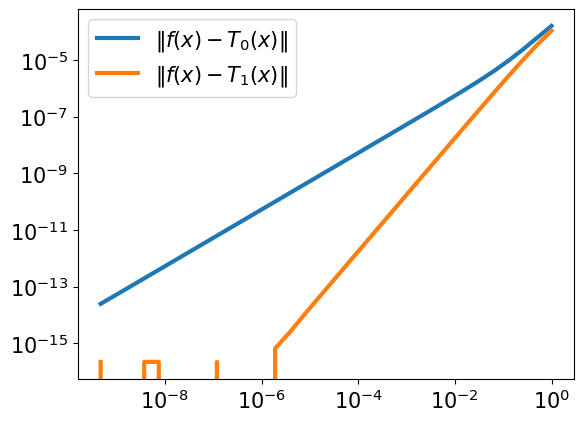

In [16]:
layers = 5

v = np.random.randn(dim)
x = np.random.randn(dim)

weights = [np.random.rand(dim, dim) for n in range(0, layers)]
biases = [np.random.randn(dim) for n in range(0, layers)]

def f(b):
  return rec_f(b, layers-1).transpose() @ v

def rec_f(b, layer):
  if layer == 0:
    return sigma(weights[layer] @ x + b)
  else:
    return sigma(weights[layer] @ rec_f(b, layer-1) + biases[layer])

def grad_f(b):
  return rec_grad_f(b, layers-1) @ v

def rec_grad_f(b, layer):
  if layer == 0:
    return sigma_prime(weights[layer] @ x + b)
  else:
    return rec_grad_f(b, layer-1) @ weights[layer].transpose() @ sigma_prime(weights[layer] @ rec_f(b, layer-1) + biases[layer])

check(f, grad_f, False)

Extending to the weights as above:

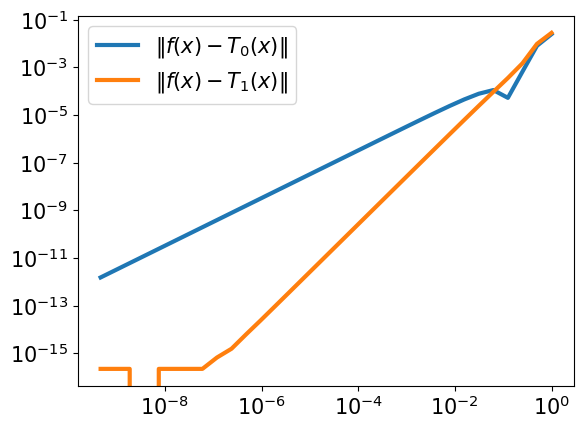

In [17]:
layers = 5

v = np.random.randn(dim)
x = np.random.randn(dim)

weights = [np.random.rand(dim, dim) for n in range(0, layers)]
biases = [np.random.randn(dim) for n in range(0, layers)]

# functions we care about

def f(W):
  return rec_f(W, layers-1).transpose() @ v

def rec_f(W, layer):
  if layer == 0:
    return sigma(W @ x + biases[layer])
  else:
    # sigma(W2 @ sigma(W1 @ z + b) + b2)
    return sigma(weights[layer] @ rec_f(W, layer-1) + biases[layer])

def grad_f(W):
  return np.outer(rec_grad_f(W, layers-1) @ v, x)

def rec_grad_f(W, layer):
  if layer == 0:
    return sigma_prime(W @ x + biases[layer])
  else:
    # sigma_prime(W1 @ z + b) @ W2.transpose() @ sigma_prime(W2 @ sigma(W1 @ z + b) + b2)
    return rec_grad_f(W, layer-1) @ weights[layer].transpose() @ sigma_prime(weights[layer] @ rec_f(W, layer-1) + biases[layer])

check_matrix(f, grad_f, False)

### There's still a bit more we need to do, however. First, what we actually care about is the gradient of the cost function, and we can modify our code to support that, both in computing our bias and our weights.

$$\nabla Cost(x,y) = \frac{1}{2}|f(x) - y|^2$$
where $x$ is our input and $y$ is our expected output.

For biases:

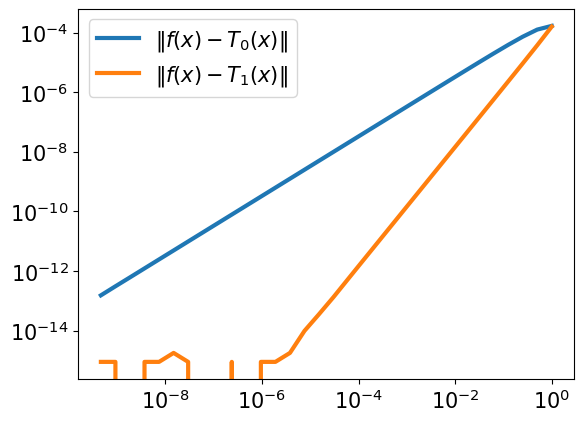

In [18]:
layers = 5

v = np.random.randn(dim)
x = np.random.randn(dim)

weights = [np.random.rand(dim, dim) for n in range(0, layers)]
biases = [np.random.randn(dim) for n in range(0, layers)]

def f(b):
  return 0.5 * np.linalg.norm(rec_f(b, layers-1) - v) ** 2

def rec_f(b, layer):
  if layer == 0:
    return sigma(weights[layer] @ x + b)
  else:
    return sigma(weights[layer] @ rec_f(b, layer-1) + biases[layer])

def grad_f(b):
  return rec_grad_f(b, layers-1) @ (rec_f(b, layers-1) - v)

def rec_grad_f(b, layer):
  if layer == 0:
    return sigma_prime(weights[layer] @ x + b)
  else:
    return rec_grad_f(b, layer-1) @ weights[layer].transpose() @ sigma_prime(weights[layer] @ rec_f(b, layer-1) + biases[layer])

check(f, grad_f, False)

For weights:

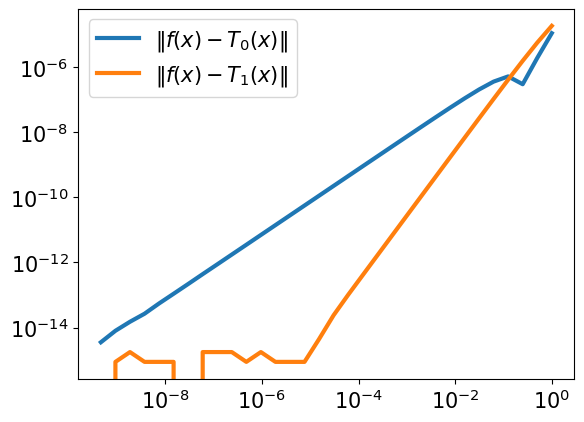

In [19]:
layers = 5

v = np.random.randn(dim)
x = np.random.randn(dim)

weights = [np.random.rand(dim, dim) for n in range(0, layers)]
biases = [np.random.randn(dim) for n in range(0, layers)]

# functions we care about

def f(W):
  return 0.5 * np.linalg.norm(rec_f(W, layers-1) - v) ** 2

def rec_f(W, layer):
  if layer == 0:
    return sigma(W @ x + biases[layer])
  else:
    # sigma(W2 @ sigma(W1 @ z + b) + b2)
    return sigma(weights[layer] @ rec_f(W, layer-1) + biases[layer])

def grad_f(W):
  return np.outer(rec_grad_f(W, layers-1) @ (rec_f(W, layers-1) - v), x)

def rec_grad_f(W, layer):
  if layer == 0:
    return sigma_prime(W @ x + biases[layer])
  else:
    # sigma_prime(W1 @ z + b) @ W2.transpose() @ sigma_prime(W2 @ sigma(W1 @ z + b) + b2)
    return rec_grad_f(W, layer-1) @ weights[layer].transpose() @ sigma_prime(weights[layer] @ rec_f(W, layer-1) + biases[layer])

check_matrix(f, grad_f, False)

### Finally, there's one subtle problem. Up to this point, we have only computed the gradient with respect to the *last* layer of weights and biases. However, in our program, we need to compute the gradients for every layer in between. The `change_later` variable below allows us to pick which layer we are solving the gradients for. 

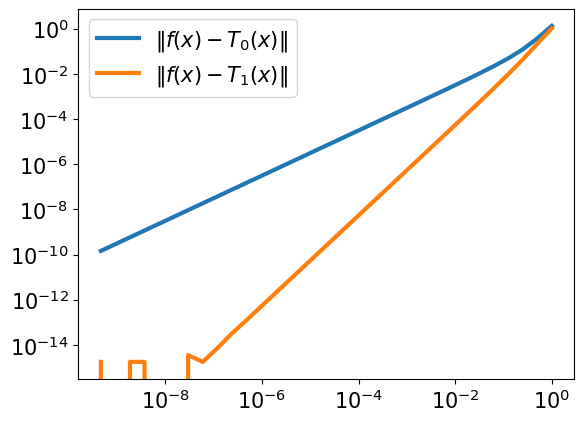

In [20]:
layers = 5
change_layer = 1

v = np.random.randn(dim)
x = np.random.randn(dim)

weights = [np.random.rand(dim, dim) for n in range(0, layers)]
biases = [np.random.randn(dim) for n in range(0, layers)]

def f(b):
  biases[change_layer] = b
  return 0.5 * np.linalg.norm(rec_f(layers-1, 0) - v) ** 2

def rec_f(current_layer, target_layer):
  if current_layer == target_layer-1:
    return x
  else:
    return sigma(weights[current_layer] @ rec_f(current_layer-1, target_layer) + biases[current_layer])

def grad_f(b):
  biases[change_layer] = b
  return rec_grad_f(layers-1, change_layer) @ (rec_f(layers-1, 0) - v)

def rec_grad_f(current_layer, target_layer):
  if current_layer == target_layer:
    return sigma_prime(weights[current_layer] @ rec_f(current_layer-1,0) + biases[current_layer])
  else:
    return rec_grad_f(current_layer-1, target_layer) @ weights[current_layer].transpose() @ sigma_prime(weights[current_layer] @ rec_f(current_layer-1, 0) + biases[current_layer])

check(f, grad_f, False)

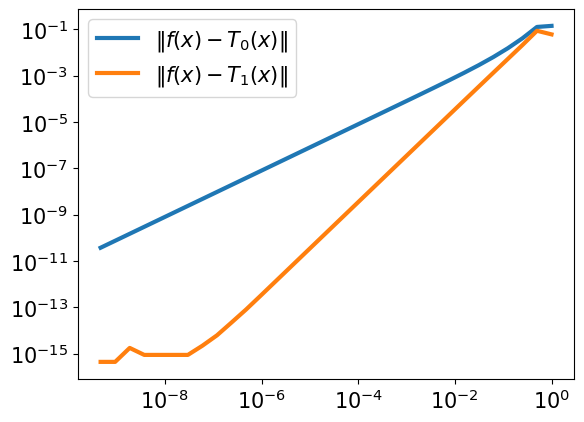

In [21]:
layers = 5
change_layer = 3

v = np.random.randn(dim)
x = np.random.randn(dim)

weights = [np.random.rand(dim, dim) for n in range(0, layers)]
biases = [np.random.randn(dim) for n in range(0, layers)]

def f(W):
  weights[change_layer] = W
  return 0.5 * np.linalg.norm(rec_f(layers-1, 0) - v) ** 2

def rec_f(current_layer, target_layer):
  if current_layer == target_layer-1:
    return x
  else:
    return sigma(weights[current_layer] @ rec_f(current_layer-1, target_layer) + biases[current_layer])

def grad_f(W):
  weights[change_layer] = W
  return np.outer(rec_grad_f(layers-1, change_layer) @ (rec_f(layers-1, 0) - v), rec_f(change_layer-1,0))

def rec_grad_f(current_layer, target_layer):
  if current_layer == target_layer:
    return sigma_prime(weights[current_layer] @ rec_f(current_layer-1,0) + biases[current_layer])
  else:
    return rec_grad_f(current_layer-1, target_layer) @ weights[current_layer].transpose() @ sigma_prime(weights[current_layer] @ rec_f(current_layer-1, 0) + biases[current_layer])


check_matrix(f, grad_f, False)

### And that's basically it! Below I've combined everything together, and also added support for different layer sizes. This will serve as the foundation of our NueralNetwork class implemented in the next tutorial.

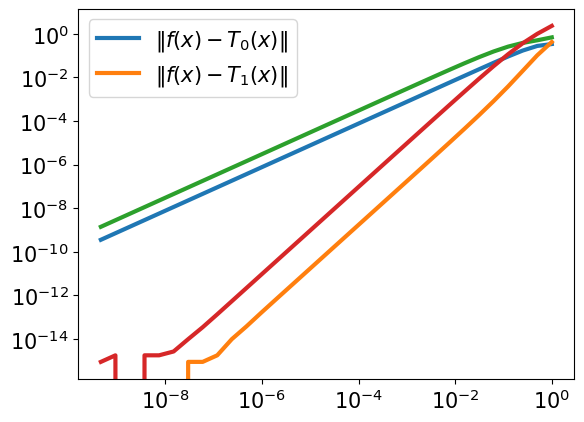

In [22]:
layers = 5
layer_dims = [3, 3]
change_layer = 1

v = np.random.randn(dim)
x = np.random.randn(dim)

weights = [np.random.rand(dim, dim) for n in range(0, layers)]
biases = [np.random.randn(dim) for n in range(0, layers)]

def f_b(b):
  biases[change_layer] = b
  return 0.5 * np.linalg.norm(rec_f(layers-1, 0) - v) ** 2

def f_w(W):
  weights[change_layer] = W
  return 0.5 * np.linalg.norm(rec_f(layers-1, 0) - v) ** 2

def rec_f(current_layer, target_layer):
  if current_layer == target_layer-1:
    return x
  else:
    return sigma(weights[current_layer] @ rec_f(current_layer-1, target_layer) + biases[current_layer])

def grad_f_b(b):
  biases[change_layer] = b
  return rec_grad_f(layers-1, change_layer) @ (rec_f(layers-1, 0) - v)

def grad_f_w(W):
  weights[change_layer] = W
  return np.outer(rec_grad_f(layers-1, change_layer) @ (rec_f(layers-1, 0) - v), rec_f(change_layer-1,0))

def rec_grad_f(current_layer, target_layer):
  if current_layer == target_layer:
    return sigma_prime(weights[current_layer] @ rec_f(current_layer-1,0) + biases[current_layer])
  else:
    return rec_grad_f(current_layer-1, target_layer) @ weights[current_layer].transpose() @ sigma_prime(weights[current_layer] @ rec_f(current_layer-1, 0) + biases[current_layer])

check(f_b, grad_f_b, False)
check_matrix(f_w, grad_f_w, False)